In [1]:
import ast
import json
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
#import plotly
#plotly.offline.init_notebook_mode(connected=True)
#import plotly.offline as py
import plotly.plotly as py
import plotly.tools as tls
import string
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from src.data import read_files
from collections import Counter
import itertools

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [161]:
# Load the first `nrows` lines of train, test
train, test = read_files()

In [162]:
hotel = train[train.iloc[:,28]=='1']
hotel.reset_index(drop=True, inplace=True)
hotel.shape

(278733, 38)

In [ ]:
train['category'] = 'Other'
train.loc[train.iloc[:,12]=='1', 'category'] = 'Restaurants'
train.loc[train.iloc[:,19]=='1', 'category'] = 'EventPlanning&Services'
train.loc[train.iloc[:,20]=='1', 'category'] = 'Shopping'
train.loc[train.iloc[:,22]=='1', 'category'] = 'Beauty&Spas'
train.loc[train.iloc[:,28]=='1', 'category'] = 'Hotels&Travel'
train.loc[train.iloc[:,32]=='1', 'category'] = 'HomeServices'
train.loc[train.iloc[:,34]=='1', 'category'] = 'Automotive'

In [ ]:
ax = sns.barplot(x="stars", y="category", data=train)

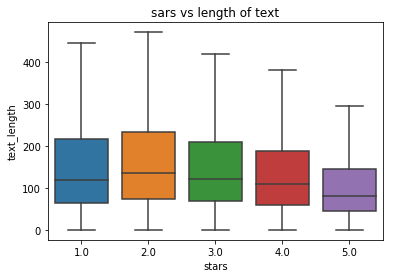

In [163]:
hotel['text_length'] = hotel['text'].apply(lambda x: len(x.split(" ")))  #get the counts of words in each review
#no obvious relationship between stars & text_length
sns.boxplot(x='stars', y='text_length', data=hotel, showfliers=False)
plt.title('sars vs length of text')
plt.show()

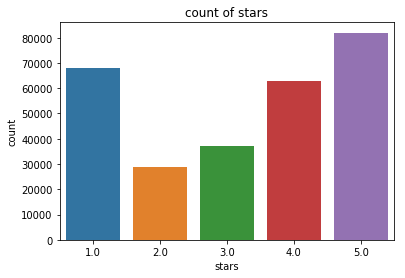

In [164]:
#5 stars is the most
ax = sns.countplot(x="stars", data=hotel)
plt.title('count of stars')
plt.show()

In [9]:
def get_wordnet_pos(treebank_tag):
    '''
    convert speach of a word in wordnet to a single alphabet
    '''
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return ''

def speech_count(s):
    s = unicode(s, "utf-8")
    tokens = nltk.word_tokenize(s.lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    counts = Counter(get_wordnet_pos(tag) for word,tag in tags)
    total = sum(counts.values())
    return dict((word, float(count)/total) for word,count in counts.items())

In [17]:
hotel['speech'] = hotel['text'].apply(lambda x: speech_count(x))

In [18]:
hotel['a'] = hotel['speech'].apply(lambda x: x['a'] if ('a' in x.keys()) else 0)
hotel['n'] = hotel['speech'].apply(lambda x: x['n'] if ('n' in x.keys()) else 0)
hotel['v'] = hotel['speech'].apply(lambda x: x['v'] if ('v' in x.keys()) else 0)
hotel['r'] = hotel['speech'].apply(lambda x: x['r'] if ('r' in x.keys()) else 0)

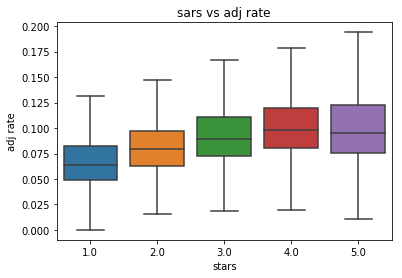

In [19]:
sns.boxplot(x='stars', y='a', data=hotel, showfliers=False)
plt.ylabel('adj rate')
plt.title('sars vs adj rate')
plt.show()

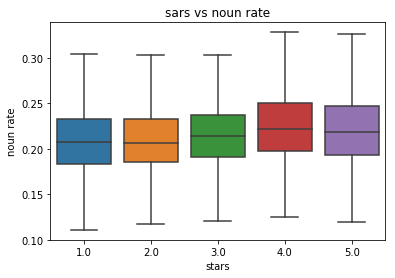

In [20]:
sns.boxplot(x='stars', y='n', data=hotel, showfliers=False)
plt.ylabel('noun rate')
plt.title('sars vs noun rate')
plt.show()

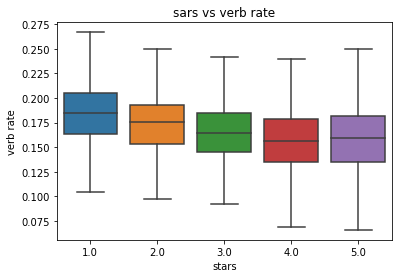

In [21]:
sns.boxplot(x='stars', y='v', data=hotel, showfliers=False)
plt.ylabel('verb rate')
plt.title('sars vs verb rate')
plt.show()

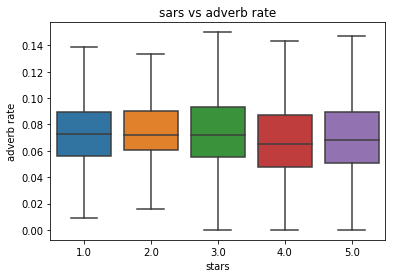

In [22]:
sns.boxplot(x='stars', y='r', data=hotel, showfliers=False)
plt.ylabel('adverb rate')
plt.title('sars vs adverb rate')
plt.show()

In [23]:
from textblob import TextBlob

In [139]:
import string
from googletrans import Translator
from langdetect import detect
translator = Translator()
    
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Detect the language of the text and translate it into english
    2. Remove all punctuation
    3. Remove all stopwords
    4. Return the cleaned text as a list of words
    '''
    s = unicode(text, "utf-8")
    if detect(s)!='en':  #translate other language to english
        #blob = blob.translate(from_lang=blob.detect_language(),to='en')
        s = translator.translate(s).text
    nopunc = [char for char in s if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [145]:
def clean_text(text):
    text = " ".join(text)
    return(text)

In [146]:
hotel['text_clean'] = hotel['text'].apply(lambda x: text_process(x))
hotel['text_clean'] = hotel['text_clean'].apply(lambda x: clean_text(x))

In [153]:
hotel['text_clean'].head()

0    Michael Red Carpet VIP amazing reached needed ...
1    Went last weekend pretty disappointed one thin...
2    company hosted dinner awards night hotel last ...
3    charged twice expected pay guy counter smallta...
4    mess line hour still 10 people front Shouldve ...
Name: text_clean, dtype: object

In [154]:
stars = ['1','2','3','4','5']
BOW_df = pd.DataFrame(columns=stars)
words_set = Set()

In [155]:
for i in range(hotel.shape[0]):
    stars = hotel['stars'][i]-1
    text = hotel['text_clean'][i].lower()
    blob = TextBlob(text)
    for word in set(blob.noun_phrases): #get unique phrase
        if word not in words_set:
            words_set.add(word)
            BOW_df.loc[word] = [0,0,0,0,0]
            BOW_df.ix[word][stars] += 1
        else:
            BOW_df.ix[word][stars] += 1

In [156]:
BOW_df.sort_values(by=['1'], ascending=False).head(50)

,1,2,3,4,5
front desk,53,26,13,11,18
customer service,41,7,5,4,10
credit card,26,4,0,2,0
rental car,25,5,1,1,9
poor customer service,15,2,2,1,0
rental company,12,1,0,1,1
rent car,12,1,0,1,3
multiple times,11,2,2,1,3
rental experience,10,0,0,0,1
yellow cab,10,0,0,0,3


In [157]:
BOW_df.sort_values(by=['2'], ascending=False).head(25)

,1,2,3,4,5
front desk,53,26,13,11,18
room service,6,8,2,11,8
customer service,41,7,5,4,10
rental car,25,5,1,1,9
hot tub,0,4,5,11,5
hot water,2,4,1,0,7
great place,1,4,2,15,12
credit card,26,4,0,2,0
bags room,0,3,0,0,1
extra charge,3,3,0,0,1


In [158]:
BOW_df.sort_values(by=['3'], ascending=False).head(25)

,1,2,3,4,5
front desk,53,26,13,11,18
free wifi,3,2,8,8,4
friendly helpful,1,1,6,15,21
hot tub,0,4,5,11,5
resort fee,0,3,5,3,5
customer service,41,7,5,4,10
nice hotel,3,1,5,10,15
hotel staff,2,0,5,2,0
nice staff,0,1,5,1,8
great prices,0,0,4,0,2


In [159]:
BOW_df.sort_values(by=['4'], ascending=False).head(25)

,1,2,3,4,5
friendly staff,1,1,2,17,9
great place,1,4,2,15,12
friendly helpful,1,1,6,15,21
great service,3,1,1,13,29
great hotel,0,2,1,11,17
front desk,53,26,13,11,18
hot tub,0,4,5,11,5
room service,6,8,2,11,8
great time,0,0,1,11,16
great location,1,1,4,11,12


In [160]:
BOW_df.sort_values(by=['5'], ascending=False).head(25)

,1,2,3,4,5
great service,3,1,1,13,29
great experience,0,1,3,7,22
las vegas,7,3,3,8,21
friendly helpful,1,1,6,15,21
front desk,53,26,13,11,18
great hotel,0,2,1,11,17
great time,0,0,1,11,16
nice hotel,3,1,5,10,15
great place,1,4,2,15,12
great location,1,1,4,11,12
